# Proyecto 2: Ingeniería de Features, modelos avanzados e interpretación de datos

Data Scientist: Felipe Orelo

¡Bienvenido/a al segundo proyecto de la carrera de Data Science de Acamica! 

El objetivo de este proyecto es lograr una mejora del proyecto n1 de la carrera, logrando generar un modelo que tenga un mejor desempeño que el anterior. Para el mismo utilizaremos el dataset llamado "Properati".

El mismo consta de tres secciones:

* PARTE A - Transformación de Datos

Elige cuáles de las siguientes tareas son apropiadas para su dataset. Implementa las transformaciones que elegiste. Es importante que justifiques por qué las haces:

1.Detección y eliminación de Outliers

2.Encoding

3.Imputación de valores faltantes

4.Escalado de datos

5.Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA).

Vuelve a entrenar el modelo implementado en la Entrega 01 - en particular, el árbol de decisión - con este nuevo dataset transformado. Evalúa su desempeño a partir del dataset obtenido luego de transformar los datos. ¿Hay una mejora en su desempeño? Compara con el desempeño obtenido en el proyecto 01. Sea cual sea la respuesta, intenta explicar a qué se debe.

* PARTE B - Modelos Avanzados

1.Elige dos de los modelos avanzados vistos Compara con el desempeño obtenido en el proyecto 01 (en el caso de regresión, considera una regresión lineal con atributos polinómicos y regularización). Entrénalos y evalúalos con sus argumentos por defecto. No te olvides de hacer un train/test split y usar Validación Cruzada.

1.Optimiza sus hiperparámetros mediante Validación Cruzada y Grid Search o Random Search.

2.Compara el desempeño de los nuevos modelos entre sí y con el modelo de la Parte A. ¿Cuál elegirías? Justifica.

* PARTE C - Interpretación de modelos

De acuerdo a lo que el modelo permite, responde algunas o todas las siguientes preguntas:

-¿Qué variables fueron relevantes para el modelo para hacer una predicción? ¿Cuáles no? Si usaste una regresión lineal con regularización, presta atención a los parámetros (pendientes) obtenidas. Si usaste un modelo de ensamble en árboles, además de ver la importancia de cada atributo, también elige algunos árboles al azar y observa qué atributos considera importantes. ¿En qué se diferencian esos árboles? ¿Por qué? Finalmente, responde, ¿coincide con lo que esperabas a partir de tu experiencia con este dataset?

-¿Cómo es la distribución de errores (regresión) o qué clases se confunden entre sí (clasificación)? ¿Dónde falla? ¿A qué se debe?.

# Parte A -Transformación de datos

In [1]:
# Importamos las librerias a utilizar.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler, RobustScaler

In [2]:
#Cargamos nuestro dataset properati.
properati = pd.read_csv("/Users/feliorelo/Documents/ACAMICA 2020/DS_Proyecto_01_Datos_Properati.csv")
properati.head(3)
properati.shape

(146660, 19)

In [3]:
#DESCARTAMOS COLUMNAS QUE NO APORTAN VALOR
columnas_descartables = ['start_date','end_date','l1','created_on','lat','lon','currency','description','title']
properati = properati.drop(columns=columnas_descartables)
properati.head(1)

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,operation_type
0,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento,Venta


In [4]:
d1 = properati[((properati['property_type']=='Departamento') | (properati['property_type']=='PH') | (properati['property_type']=='Casa')) & (properati['l2']=='Capital Federal')]

#Eliminamos propiedades con superficie cubierta mayor a total.
print(d1.isnull().sum())
d2 = d1[(d1['surface_covered'] < d1['surface_total'])]

l2                    0
l3                    0
rooms                 0
bedrooms              0
bathrooms          2171
surface_total      8917
surface_covered    9235
price                 0
property_type         0
operation_type        0
dtype: int64


In [5]:
#Ademas vamos a considerar solo las ventas para el valor de las propiedades.
d3 = d2[(d2['operation_type']=='Venta')]

<AxesSubplot:xlabel='property_type', ylabel='count'>

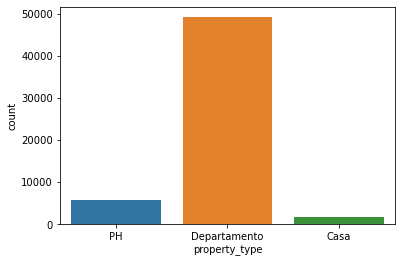

In [6]:
#Observar si los datos se encuentran desbalanceados.

sns.countplot(data = d3, x = 'property_type')



Podemos observar que los datos se encuentran desbalanceados, ya que principalmente son departamentos.
Tenemos dos opciones o aplicamos Stratify a departamentos en train, test, split o directamente armamos un modelo para cada tipo de propiedad.
Optaremos por la primer opción.

In [7]:
# Instancias nulas o valores faltantes por columna.
d3.isnull().sum()

l2                   0
l3                   0
rooms                0
bedrooms             0
bathrooms          527
surface_total        0
surface_covered      0
price                0
property_type        0
operation_type       0
dtype: int64

Antes de completar los valores nulos vamos a separar en un train test split, con la finalidad de no cesgar nuestros dataset.

In [8]:
d3_copia = d3

columnas_entrenamiento_X = ['l2','l3','rooms','bedrooms','bathrooms','surface_total','surface_covered','property_type']
columnas_entrenamiento_y = ['price']
X = d3_copia[columnas_entrenamiento_X]
y = d3_copia[columnas_entrenamiento_y]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = X['property_type'], random_state=42)
X_train.reset_index(inplace=True,drop=True) 
y_train.reset_index(inplace=True,drop=True) 
X_test.reset_index(inplace=True,drop=True) 
y_test.reset_index(inplace=True,drop=True)

Reseteamos el indice de los datos antes de preprocesarlos, de esta manera no exisitiran inconvenientes a la hora de preprocesar en las distintas particiones de train test .

In [10]:
X_train.isnull().sum()

l2                   0
l3                   0
rooms                0
bedrooms             0
bathrooms          376
surface_total        0
surface_covered      0
property_type        0
dtype: int64

In [11]:
X_test.isnull().sum()

l2                   0
l3                   0
rooms                0
bedrooms             0
bathrooms          151
surface_total        0
surface_covered      0
property_type        0
dtype: int64

##Una vez separados los datos, pasamos a imputar valores faltantes. Para esto agrupamos a travez de groupby y utilizamos valores de inmuebles similares para cada valor missing. En el caso de los baños utilizamos la mediana y en el caso de las superficies el promedio.
La variable categorica no cuenta con valores faltantes.##

In [12]:
X_train_1 = X_train.copy()
X_test_1 = X_test.copy()

In [13]:
#Imputando valores faltantes X_train para bathrooms, ya que son los unicos en este caso.
imputer = X_train_1.groupby('rooms', as_index=False)['bathrooms'].median()

for index, row in imputer.iterrows():
    results = dict(row)
    X_train_1.loc[(X_train_1['rooms'] == results['rooms']) &
                (X_train_1['bathrooms'].isna()), 'bathrooms'] = results['bathrooms']

for index, row in imputer.iterrows():
    results = dict(row)
    X_test_1.loc[(X_test_1['rooms'] == results['rooms']) &
                (X_test_1['bathrooms'].isna()), 'bathrooms'] = results['bathrooms']
print('nulos X_test:\n',X_test_1.isna().sum())
print('nulos X_train:\n',X_train_1.isna().sum())

nulos X_test:
 l2                 0
l3                 0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
property_type      0
dtype: int64
nulos X_train:
 l2                 0
l3                 0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
property_type      0
dtype: int64


In [14]:
#Para entender un poco lo que hicimos arriba dejamos un groupby 
#Se reemplazo cada valor missing teniendo en cuenta la cantidad de rooms y la correspondencia
#con los baños y superficies.

groupby = X_train_1.groupby('rooms').agg({'bathrooms':'median','surface_total':'mean','surface_covered':'mean'})
print(groupby)

       bathrooms  surface_total  surface_covered
rooms                                           
1.0          1.0      54.155052        42.320440
2.0          1.0      62.930019        48.727594
3.0          1.0     106.735013        76.228155
4.0          2.0     149.804333       117.032611
5.0          2.0     272.486224       168.971637
6.0          3.0     274.258953       215.468320
7.0          3.0     371.252830       265.977358
8.0          3.0     396.038961       308.259740
9.0          3.0     421.033333       294.433333
10.0         3.0     471.148148       355.481481
11.0         4.0     454.125000       336.375000
12.0         3.0     497.588235       351.176471
15.0         7.0     451.666667       255.000000
16.0         4.0     476.000000       297.000000
18.0         3.0     575.000000       552.000000
26.0         7.0     845.000000       835.000000


El paso siguiente es estandarizar los datos, antes de realizar esto veremos la distribución de los datos tanto en train como en test.
De esta manera podemos ir observando si una vez estandarizados varia su distribución, si sucede esto, estariamos cesgando nuestros datos.

Para estandarizar los datos, lo que haremos a continuación sera estandarizar por tipo de propiedad, de tal manera que no se mezclen los promedios ni las desviaciones estandares de cada tipo.

Esto mejorara la predicción de precio para cada tipo de unidad.

Comenzamos trabajando con X_train_1 y X_test_1.

In [15]:
numerical_features = ['rooms', 'bedrooms', 'bathrooms',
                      'surface_total', 'surface_covered']

categorical_features = ['l2','l3']
property_type = ['property_type']

property_type_list = X_train_1['property_type'].values
property_type_list = list(set(property_type_list))

In [16]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler

scalers = {}

for column in property_type:
    for category in sorted(X_train_1[column].unique().tolist()):
        scalers[column] = [StandardScaler().fit(X_train_1.loc[X_train_1[column] == category, numerical_features])
                           for category in X_train_1[column].unique().tolist()]

scalers

{'property_type': [StandardScaler(), StandardScaler(), StandardScaler()]}

In [17]:
for column in property_type:
    for i, category in enumerate(sorted(X_train_1[column].unique().tolist())):
        X_train_1.loc[X_train_1[column] == category,
                    numerical_features] = scalers[column][i].transform(X_train_1.loc[X_train_1[column] == category,
                                                                                   numerical_features])

In [18]:
for column in property_type:
    for i, category in enumerate(sorted(X_train_1[column].unique().tolist())):
        X_test_1.loc[X_test_1[column] == category,
                   numerical_features] = scalers[column][i].transform(X_test_1.loc[X_test_1[column] == category,
                                                                                 numerical_features])

Una vez con los datos estandarizados, comenzamos con la transformación de las variables categoricas.

In [19]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False).fit(X_train_1[categorical_features])
ohe_df = pd.DataFrame(ohe.transform(X_train_1[categorical_features]), columns=ohe.get_feature_names())

X_train_1.drop(categorical_features, axis=1, inplace=True)
X_train_1 = pd.concat([X_train_1.reset_index(drop=True), ohe_df], axis=1)
X_train_1

,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type,x0_Capital Federal,x1_Abasto,x1_Agronomía,x1_Almagro,...,x1_Villa Lugano,x1_Villa Luro,x1_Villa Ortuzar,x1_Villa Pueyrredón,x1_Villa Real,x1_Villa Riachuelo,x1_Villa Santa Rita,x1_Villa Soldati,x1_Villa Urquiza,x1_Villa del Parque
0,-0.459882,-0.415189,0.562464,-0.047684,-0.291582,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.206501,-1.266954,-0.697728,-0.066250,-0.832176,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.206501,-1.266954,-0.697728,-0.073274,-1.061518,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.206501,-1.266954,-0.697728,-0.064242,-0.766649,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.286737,-0.415189,-0.697728,-0.044171,-0.127766,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39655,-1.206501,-1.266954,-0.697728,-0.070766,-0.979610,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39656,-1.206501,-1.266954,-0.697728,-0.076787,-1.159808,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39657,-0.459882,-0.415189,0.562464,-0.053705,-0.422635,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39658,0.094752,-1.189860,-0.235764,-0.305851,-0.388822,PH,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
X_train_1.shape

(39660, 64)

Como no hay datos nulos no realizamos ningun imputer. Continuamos con la trasformación de los datos en test.

In [21]:
ohe_df = pd.DataFrame(ohe.transform(X_test_1[categorical_features]), columns=ohe.get_feature_names())

In [22]:
X_test_1.drop(categorical_features, axis=1, inplace=True)
X_test_1 = pd.concat([X_test_1.reset_index(drop=True), ohe_df], axis=1)
X_test_1


,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type,x0_Capital Federal,x1_Abasto,x1_Agronomía,x1_Almagro,...,x1_Villa Lugano,x1_Villa Luro,x1_Villa Ortuzar,x1_Villa Pueyrredón,x1_Villa Real,x1_Villa Riachuelo,x1_Villa Santa Rita,x1_Villa Soldati,x1_Villa Urquiza,x1_Villa del Parque
0,-1.953120,-1.266954,-0.697728,-0.075282,-1.110663,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.459882,-0.415189,0.562464,-0.030623,0.003287,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.526053,-0.337624,-0.235764,-0.082292,-0.642194,PH,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.459882,-0.415189,-0.697728,-0.058221,-0.537306,Departamento,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.206501,-1.266954,0.562464,-0.061734,-0.701123,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16993,-0.459882,-0.415189,-0.697728,-0.058723,-0.684741,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16994,-0.459882,-0.415189,0.562464,-0.040157,-0.471780,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16995,-1.146857,-1.189860,-1.174904,-0.476808,-1.056036,PH,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16996,-1.953120,-1.266954,-0.697728,-0.073274,-1.094281,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Luego de realizar la estandarización y la imputación de los datos missing observemos si sigue existiendo una correlación en la distribución de los datos tanto de train como de test.

/Users/feliorelo/opt/anaconda3/envs/acamica/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/feliorelo/opt/anaconda3/envs/acamica/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/feliorelo/opt/anaconda3/envs/acamica/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  war

Text(0.5, 1.0, 'Distribución variable rooms Datos Test')

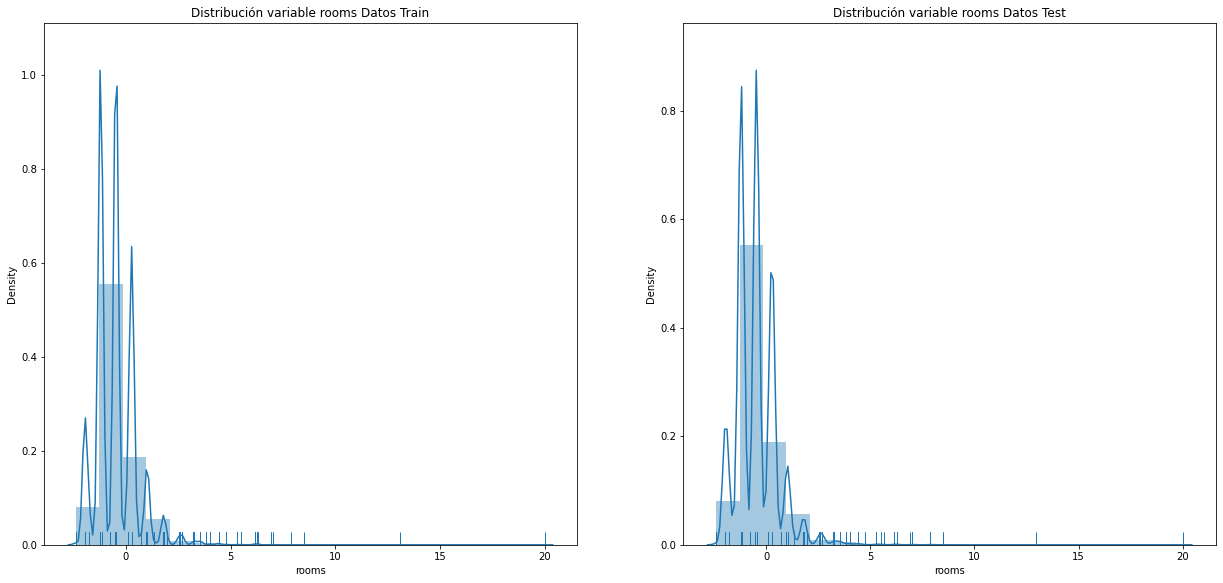

In [23]:
plt.figure(figsize = (7*3,4.8*2))

plt.subplot(1,2,1)
sns.distplot(X_train_1['rooms'], bins = 20, rug = True)
plt.title('Distribución variable rooms Datos Train')


plt.subplot(1,2,2)
sns.distplot(X_test_1['rooms'], bins = 20, rug = True)

plt.title('Distribución variable rooms Datos Test')

A partir de aca continuamos trabajando con X_test_1,
X_train_1. Ya con los datos Standarizados y nulos imputados.

Ahora comenzamos con la detección de outliers y ver como los podemos manejar.

/Users/feliorelo/opt/anaconda3/envs/acamica/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rooms'>

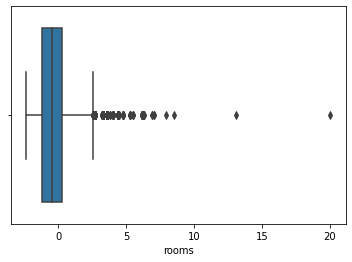

In [24]:
sns.boxplot(X_train_1.rooms)

<AxesSubplot:xlabel='bedrooms'>

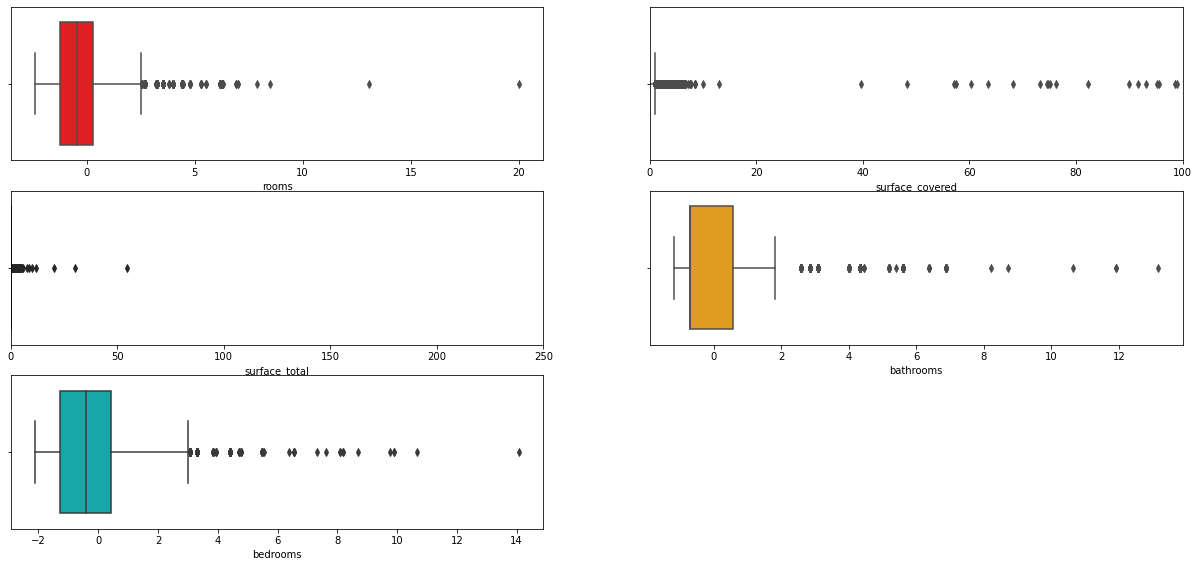

In [25]:
plt.figure(figsize = (7*3,4.8*2))

plt.subplot(3,2,1)
sns.boxplot(data = X_train_1, x = 'rooms', color = 'r')

plt.subplot(3,2,2)
sns.boxplot(data = X_train_1, x = 'surface_covered', color = 'r')
plt.xlim(0, 100)

plt.subplot(3,2,3)
sns.boxplot(data = X_train_1, x = 'surface_total', color = 'g')
plt.xlim(0, 250)

plt.subplot(3,2,4)
sns.boxplot(data = X_train_1, x = 'bathrooms', color = 'orange')

plt.subplot(3,2,5)
sns.boxplot(data = X_train_1, x = 'bedrooms', color = 'c')

/Users/feliorelo/opt/anaconda3/envs/acamica/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bathrooms'>

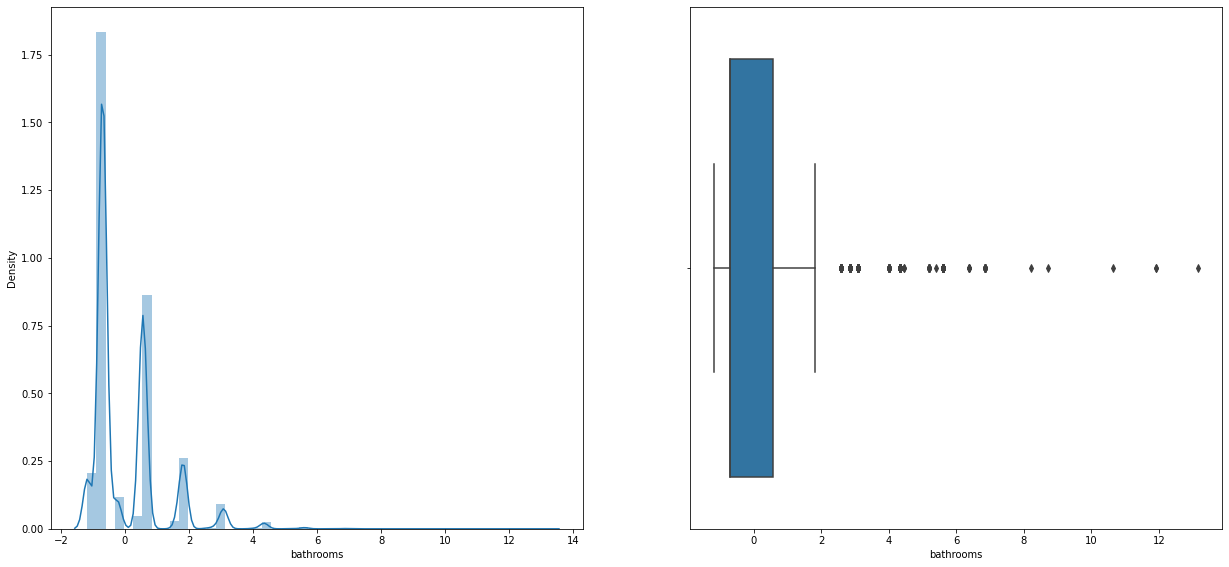

In [26]:
plt.figure(figsize = (7*3,4.8*2))

plt.subplot(1,2,1)
sns.distplot(a = X_train_1['bathrooms'], kde=True, hist=True)
plt.subplot(1,2,2)
sns.boxplot(data = X_train_1, x = 'bathrooms')

En todas las variables nos encontramos con datos atípicos, por afuera de los bigotes de los boxplots.
En el caso de los baños podemos observar que la mayor concentración se encuentra entre -1 y 1, recordemos que los datos se encuentran estandarizados.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 [Text(0, 0, '-1.1749036494497036'),
  Text(1, 0, '-0.6977280376745534'),
  Text(2, 0, '-0.6744990598198093'),
  Text(3, 0, '-0.23576399898957381'),
  Text(4, 0, '0.49886460755864853'),
  Text(5, 0, '0.5624637315713494'),
  Text(6, 0, '0.7033756514705559'),
  Text(7, 0, '1.6425153019306855'),
  Text(8, 0, '1.6722282749371062'),
  Text(9, 0, '1.8226555008172522'),
  Text(10, 0, '2.5816549523908154'),
  Text(11, 0, '2.845591942315564'),
  Text(12, 0, '3.0828472700631546'),
  Text(13, 0, '4.018955609694022'),
  Text(14, 0, '4.343039039309057'),
  Text(15, 0, '4.459934253311075'),
  Text(16, 0, '5.19231927707248'),
  Text(17, 0, '5.399073903771205'),
  Text(18, 0, '5.603230808554961'),
  Text(19, 0, '6.3656829444509375'),
  Text(20, 0, '6.863422577800863'),
  Text(21, 0, '8.216492855151595'),
  Text(22, 0, '8.712410279207853'),
  Text(23, 0, '10.643997885538573'),
  Tex

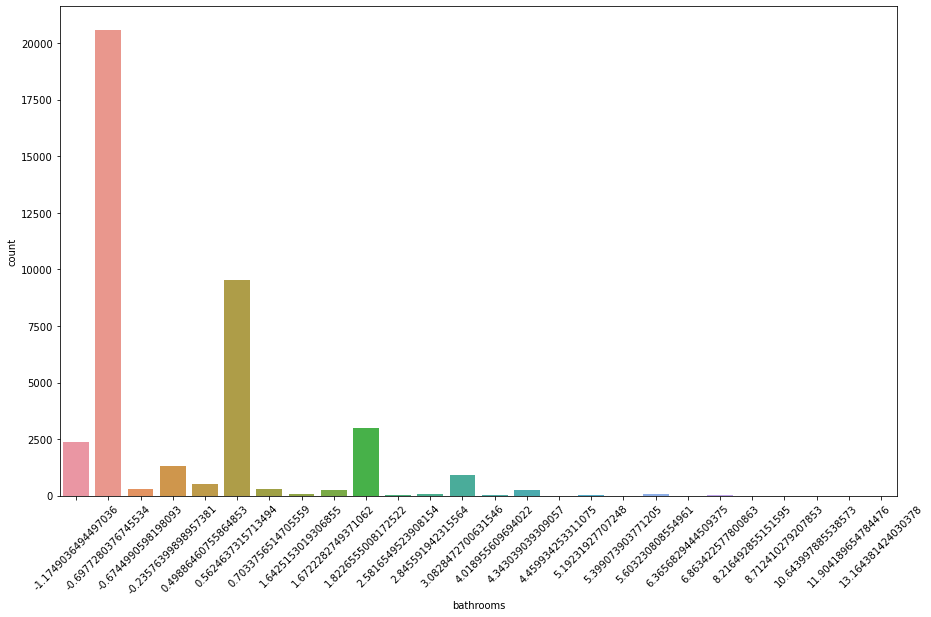

In [27]:
plt.figure(figsize = (15,9))
sns.countplot(data = X_train_1, x = 'bathrooms')
plt.xticks(rotation=45)

Una vez observados los gráficos, procedemos a realizar el manejo de outliers, al igual que la estandarización, lo haremos según el tipo de propiedad, ya que por ejemplo suelen haber casas con grandes dimensiones de superficies que en el caso de los departamentos son valores atípicos.
Ya que ninguna variable sigue una distribución normal, se trataran los datos atípicos con IQR (rango intercuartilico), es decir se eliminaran los que se encuentren por afuera de este rango.


In [28]:
X_train_2 = X_train_1.copy()
X_test_2 = X_test_1.copy()

In [29]:
iqr_features = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']

In [30]:
from collections import Counter
q3 = X_train_2[iqr_features].quantile(0.75).to_dict()
q1 = X_train_2[iqr_features].quantile(0.25).to_dict()

iqr = dict(Counter(q3) - Counter(q1))

print(q3)
print(q1)
print(iqr)

{'rooms': 0.28673693811245204, 'bedrooms': 0.43657712263099807, 'bathrooms': 0.5624637315713494, 'surface_total': -0.039655195009896116, 'surface_covered': -0.14414771794970915}
{'rooms': -1.206500808827009, 'bedrooms': -1.266954358759121, 'bathrooms': -0.6977280376745534, 'surface_total': -0.06825665388241738, 'surface_covered': -0.8977019633778789}
{'rooms': 1.493237746939461, 'bedrooms': 1.703531481390119, 'bathrooms': 1.2601917692459028, 'surface_total': 0.02860145887252126, 'surface_covered': 0.7535542454281697}


In [31]:
for feature in set(q3.keys()) & set(q1.keys()) & set(iqr.keys()):
    X_train_2[f'{feature}_ind'] = X_train_2[feature].apply(lambda x: 1 if x > q3[feature] + 1.5 * iqr[feature] else
                                                       (1 if x < q1[feature] - 1.5 * iqr[feature] else 0))

ind_features = [column for column in X_train_2.columns if column.endswith('ind')]

#X_train['sum_outliers'] = X_train[ind_features].sum(axis=1)

X_train_2.append(X_train_2.tail())

,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type,x0_Capital Federal,x1_Abasto,x1_Agronomía,x1_Almagro,...,x1_Villa Riachuelo,x1_Villa Santa Rita,x1_Villa Soldati,x1_Villa Urquiza,x1_Villa del Parque,bedrooms_ind,rooms_ind,bathrooms_ind,surface_covered_ind,surface_total_ind
0,-0.459882,-0.415189,0.562464,-0.047684,-0.291582,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
1,-1.206501,-1.266954,-0.697728,-0.066250,-0.832176,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
2,-1.206501,-1.266954,-0.697728,-0.073274,-1.061518,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
3,-1.206501,-1.266954,-0.697728,-0.064242,-0.766649,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
4,0.286737,-0.415189,-0.697728,-0.044171,-0.127766,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39655,-1.206501,-1.266954,-0.697728,-0.070766,-0.979610,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
39656,-1.206501,-1.266954,-0.697728,-0.076787,-1.159808,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
39657,-0.459882,-0.415189,0.562464,-0.053705,-0.422635,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
39658,0.094752,-1.189860,-0.235764,-0.305851,-0.388822,PH,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1


In [32]:
for feature in set(q3.keys()) & set(q1.keys()) & set(iqr.keys()):
    X_test_2[f'{feature}_ind'] = X_test_2[feature].apply(lambda x: 1 if x > q3[feature] + 1.5 * iqr[feature] else
                                                    (1 if x < q1[feature] - 1.5 * iqr[feature] else 0))

#X_test_2['sum_outliers'] = X_test_2[ind_features].sum(axis=1)

X_test_2.append(X_test_2.tail())


,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type,x0_Capital Federal,x1_Abasto,x1_Agronomía,x1_Almagro,...,x1_Villa Riachuelo,x1_Villa Santa Rita,x1_Villa Soldati,x1_Villa Urquiza,x1_Villa del Parque,bedrooms_ind,rooms_ind,bathrooms_ind,surface_covered_ind,surface_total_ind
0,-1.953120,-1.266954,-0.697728,-0.075282,-1.110663,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
1,-0.459882,-0.415189,0.562464,-0.030623,0.003287,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
2,-0.526053,-0.337624,-0.235764,-0.082292,-0.642194,PH,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
3,-0.459882,-0.415189,-0.697728,-0.058221,-0.537306,Departamento,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
4,-1.206501,-1.266954,0.562464,-0.061734,-0.701123,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16993,-0.459882,-0.415189,-0.697728,-0.058723,-0.684741,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
16994,-0.459882,-0.415189,0.562464,-0.040157,-0.471780,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
16995,-1.146857,-1.189860,-1.174904,-0.476808,-1.056036,PH,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
16996,-1.953120,-1.266954,-0.697728,-0.073274,-1.094281,Departamento,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0


Eliminamos las filas que contengan outliers en las variables segun el tipo de propiedad, recordando que todas aquellas columnas terminadas en ind son los outliers en las filas =1.

In [33]:
iqr_features_ind = ['rooms_ind', 'bedrooms_ind', 'bathrooms_ind', 'surface_total_ind', 'surface_covered_ind']


In [34]:
indices_deptos = X_train_2[(X_train_2['property_type'] == 'Departamento') & (X_train_2['rooms_ind'] == 0) & (X_train_2['property_type'] == 'Departamento') & (X_train_2['bathrooms_ind'] == 0) & (X_train_2['property_type'] == 'Departamento') & (X_train_2['surface_total_ind'] == 0) & (X_train_2['property_type'] == 'Departamento') & (X_train_2['surface_covered_ind'] == 0)].index.tolist()
indices_ph = X_train_2[(X_train_2['property_type'] == 'PH') & (X_train_2['rooms_ind'] == 0) & (X_train_2['property_type'] == 'PH') & (X_train_2['bathrooms_ind'] == 0) & (X_train_2['property_type'] == 'PH') & (X_train_2['surface_total_ind'] == 0) & (X_train_2['property_type'] == 'PH') & (X_train_2['surface_covered_ind'] == 0)].index.tolist()
indices_casas = X_train_2[(X_train_2['property_type'] == 'Casa') & (X_train_2['rooms_ind'] == 0) & (X_train_2['property_type'] == 'Casa') & (X_train_2['bathrooms_ind'] == 0) & (X_train_2['property_type'] == 'Casa') & (X_train_2['surface_total_ind'] == 0) & (X_train_2['property_type'] == 'Casa') & (X_train_2['surface_covered_ind'] == 0)].index.tolist()


In [35]:
indices_total = indices_deptos + indices_ph + indices_casas
indices_t = list(set(indices_total))

In [36]:
X_train_3 = X_train_2.loc[indices_t,:]

In [37]:
y_train_3 = y_train.loc[indices_t,:]

Aplicamos lo mismo para los datos en test.

In [38]:
indices_deptos_t = X_test_2[(X_test_2['property_type'] == 'Departamento') & (X_test_2['rooms_ind'] == 0) & (X_test_2['property_type'] == 'Departamento') & (X_test_2['bathrooms_ind'] == 0) & (X_test_2['property_type'] == 'Departamento') & (X_test_2['surface_total_ind'] == 0) & (X_test_2['property_type'] == 'Departamento') & (X_test_2['surface_covered_ind'] == 0)].index.tolist()
indices_ph_t = X_test_2[(X_test_2['property_type'] == 'PH') & (X_test_2['rooms_ind'] == 0) & (X_test_2['property_type'] == 'PH') & (X_test_2['bathrooms_ind'] == 0) & (X_test_2['property_type'] == 'PH') & (X_test_2['surface_total_ind'] == 0) & (X_test_2['property_type'] == 'PH') & (X_test_2['surface_covered_ind'] == 0)].index.tolist()
indices_casas_t = X_test_2[(X_test_2['property_type'] == 'Casa') & (X_test_2['rooms_ind'] == 0) & (X_test_2['property_type'] == 'Casa') & (X_test_2['bathrooms_ind'] == 0) & (X_test_2['property_type'] == 'Casa') & (X_test_2['surface_total_ind'] == 0) & (X_test_2['property_type'] == 'Casa') & (X_test_2['surface_covered_ind'] == 0)].index.tolist()

In [39]:
indices_tot = indices_deptos_t + indices_ph_t + indices_casas_t
indices_t1 = list(set(indices_tot))

In [40]:
X_test_3 = X_test_2.loc[indices_t1,:]

In [41]:
y_test_3 = y_test.loc[indices_t1,:]

Una vez manejado los outliers por tipo de propiedad, verificamos nuevamente que no se haya modificado la distribución de los datos.

/Users/feliorelo/opt/anaconda3/envs/acamica/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/feliorelo/opt/anaconda3/envs/acamica/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/feliorelo/opt/anaconda3/envs/acamica/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  war

Text(0.5, 1.0, 'Distribución variable rooms Datos Test')

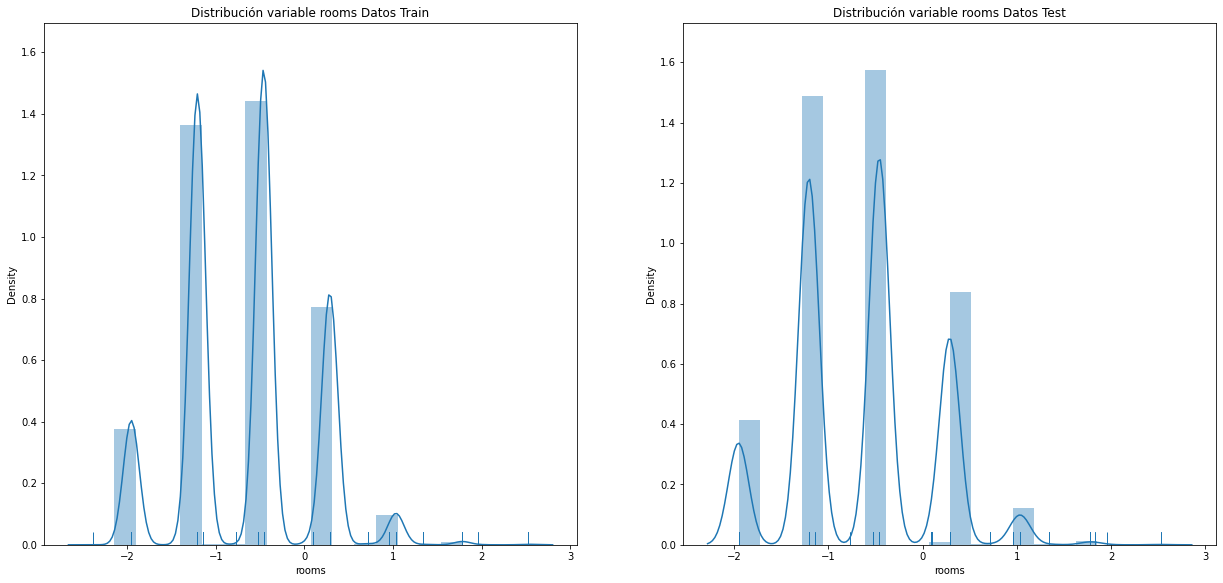

In [42]:
plt.figure(figsize = (7*3,4.8*2))

plt.subplot(1,2,1)
sns.distplot(X_train_3['rooms'], bins = 20, rug = True)
plt.title('Distribución variable rooms Datos Train')


plt.subplot(1,2,2)
sns.distplot(X_test_3['rooms'], bins = 20, rug = True)

plt.title('Distribución variable rooms Datos Test')



Una vez que verificamos las distribuciones y no vamos a utilizar nuevamente property type, procedemos a transformar esta variable con un Onehoencoder.

In [43]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False).fit(X_train_3[property_type])
ohe_df = pd.DataFrame(ohe.transform(X_train_3[property_type]), columns=ohe.get_feature_names())

X_train_3.drop(property_type, axis=1, inplace=True)
X_train_3 = pd.concat([X_train_3.reset_index(drop=True), ohe_df], axis=1)
X_train_3

,rooms,bedrooms,bathrooms,surface_total,surface_covered,x0_Capital Federal,x1_Abasto,x1_Agronomía,x1_Almagro,x1_Balvanera,...,x1_Villa Urquiza,x1_Villa del Parque,bedrooms_ind,rooms_ind,bathrooms_ind,surface_covered_ind,surface_total_ind,x0_Casa,x0_Departamento,x0_PH
0,-0.459882,-0.415189,0.562464,-0.047684,-0.291582,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0.0,1.0,0.0
1,-1.206501,-1.266954,-0.697728,-0.066250,-0.832176,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0.0,1.0,0.0
2,-1.206501,-1.266954,-0.697728,-0.073274,-1.061518,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0.0,1.0,0.0
3,-1.206501,-1.266954,-0.697728,-0.064242,-0.766649,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0.0,1.0,0.0
4,0.286737,-0.415189,-0.697728,-0.044171,-0.127766,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31693,0.286737,0.436577,0.562464,-0.055712,-0.471780,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0.0,1.0,0.0
31694,-1.206501,-1.266954,-0.697728,-0.070766,-0.979610,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0.0,1.0,0.0
31695,-1.206501,-1.266954,-0.697728,-0.076787,-1.159808,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0.0,1.0,0.0
31696,-0.459882,-0.415189,0.562464,-0.053705,-0.422635,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0.0,1.0,0.0


In [44]:
ohe_df = pd.DataFrame(ohe.transform(X_test_3[property_type]), columns=ohe.get_feature_names())
X_test_3.drop(property_type, axis=1, inplace=True)
X_test_3 = pd.concat([X_test_3.reset_index(drop=True), ohe_df], axis=1)
X_test_3



,rooms,bedrooms,bathrooms,surface_total,surface_covered,x0_Capital Federal,x1_Abasto,x1_Agronomía,x1_Almagro,x1_Balvanera,...,x1_Villa Urquiza,x1_Villa del Parque,bedrooms_ind,rooms_ind,bathrooms_ind,surface_covered_ind,surface_total_ind,x0_Casa,x0_Departamento,x0_PH
0,-1.953120,-1.266954,-0.697728,-0.075282,-1.110663,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0.0,1.0,0.0
1,-0.459882,-0.415189,0.562464,-0.030623,0.003287,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0.0,1.0,0.0
2,-0.526053,-0.337624,-0.235764,-0.082292,-0.642194,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0.0,0.0,1.0
3,-0.459882,-0.415189,-0.697728,-0.058221,-0.537306,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0,0,0,0,0,0.0,1.0,0.0
4,-1.206501,-1.266954,0.562464,-0.061734,-0.701123,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0,0,0,0,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13559,0.286737,0.436577,0.562464,-0.020086,0.609407,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0.0,1.0,0.0
13560,-0.459882,-0.415189,-0.697728,-0.058723,-0.684741,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0.0,1.0,0.0
13561,-0.459882,-0.415189,0.562464,-0.040157,-0.471780,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0.0,1.0,0.0
13562,-1.953120,-1.266954,-0.697728,-0.073274,-1.094281,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0.0,1.0,0.0


In [45]:
X_train_3.reset_index(inplace=True,drop=True) 
y_train_3.reset_index(inplace=True,drop=True) 
X_test_3.reset_index(inplace=True,drop=True) 
y_test_3.reset_index(inplace=True,drop=True)

Una vez que utilizamos los filtros eliminamos las columnas que no utilizaremos, en este caso: 
rooms_ind	surface_total_ind	surface_covered_ind	bathrooms_ind	bedrooms_ind

In [46]:
X_train_3.drop(['rooms_ind', 'surface_total_ind', 'surface_covered_ind', 'bathrooms_ind', 'bedrooms_ind'], axis = 'columns', inplace=True)
X_test_3.drop(['rooms_ind', 'surface_total_ind', 'surface_covered_ind', 'bathrooms_ind', 'bedrooms_ind'], axis = 'columns', inplace=True)



Antes de comenzar con los modelos avanzados, realizaremos un arbol de decisión para poder compararlo con el modelo realizado en el proyecto anterior.

Lo primero que haremos sera observar los hiperparámetros de nuestro modelo, en este caso la profundidad del arbol de decisión, y ver cual nos conviene elegir para obtener un error adecuado que nos permita obtener un modelo intermedio entre overfitting y underfitting.

In [47]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#Identificamos mejor la cantidad adecuada de la maxima profundidad.
# Definimos las listas vacias para los valores de accuracy deseados
lista_mae_train = []
lista_mae_test = []

# Definimos la lista de valores de k que vamos a explorar
max_depth = [1,2,3,4,5,6,7,8,9,10,15,20]

# Generamos un loop sobre los distintos valores de k 
for k in max_depth:
    
    # Vamos a repetir el siguiente bloque de código
    
    # Definir el modelo con el valor de vecinos deseado
    tree = DecisionTreeRegressor(max_depth=k, random_state=42)
    
    # Entrenar el modelo
    tree.fit(X_train_3, y_train_3)
    
    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred = tree.predict(X_train_3)
    train_mae = np.sqrt(mean_absolute_error(y_train_3, y_train_pred))
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred = tree.predict(X_test_3)
    test_mae = np.sqrt(mean_absolute_error(y_test_3, y_test_pred))
    
    # Agregar la información a las listas
    lista_mae_train.append(train_mae)
    lista_mae_test.append(test_mae)

Text(0, 0.5, 'Error MAE')

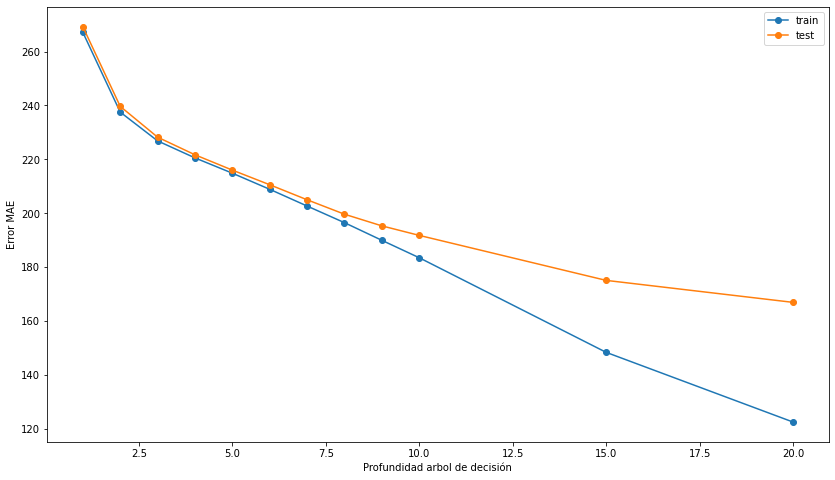

In [48]:
plt.figure(figsize=(14,8))
plt.plot(max_depth,lista_mae_train,'o-',label='train' )
plt.plot(max_depth,lista_mae_test,'o-',label='test')
plt.legend()
plt.xlabel('Profundidad arbol de decisión')
plt.ylabel('Error MAE')

Una vez observadas la gráfica podemos definir el siguiente parametros:
    
-Mejor profundidad para el arbol de decisión: 15
    
Luego podemos proceder con el modelo de machine learning utilizando los valores seleccionados.

In [49]:
tree_regressor = DecisionTreeRegressor(max_depth=15, random_state=42)

In [50]:
tree_regressor.fit(X_train_3, y_train_3)

DecisionTreeRegressor(max_depth=15, random_state=42)

In [51]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#evaluación del modelo en train
print(f'El RMSE es: {np.sqrt(mean_squared_error(y_train_3, tree_regressor.predict(X_train_3)))}')
print(f'El MAE es: {mean_absolute_error(y_train_3, tree_regressor.predict(X_train_3))}')

El RMSE es: 35704.73592839566
El MAE es: 22029.52587218273


In [52]:
#Luego en test
print(f'El RMSE es: {np.sqrt(mean_squared_error(y_test_3, tree_regressor.predict(X_test_3)))}')
print(f'El MAE es: {mean_absolute_error(y_test_3, tree_regressor.predict(X_test_3))}')

El RMSE es: 55701.544975885234
El MAE es: 30666.242685363897


In [53]:
prediction_t = tree_regressor.predict(X_train_3)
prediction_train = prediction_t.reshape(31698,1)


In [54]:
prediction_te = tree_regressor.predict(X_test_3)
prediction_test = prediction_te.reshape(13564,1)

/Users/feliorelo/opt/anaconda3/envs/acamica/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/feliorelo/opt/anaconda3/envs/acamica/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'y_pred (test)')

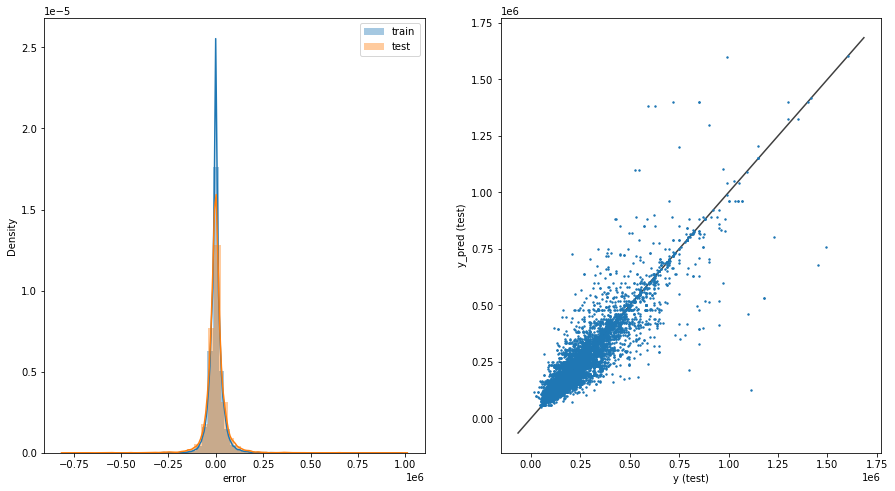

In [55]:
import seaborn as sns

plt.figure(figsize = (15,8))
plt.subplot(1,2,1)
sns.distplot(y_train_3 - prediction_train, label = 'train')
sns.distplot(y_test_3 - prediction_test, label = 'test')
plt.xlabel('error')
plt.legend()

ax = plt.subplot(1,2,2)
ax.scatter(y_test_3,prediction_test, s =2)
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

Observando el error del modelo, podemos ver que la mayor densidad de los errores se encuentran cercanos a cero, es decir que el modelo esta funcionando mucho mejor que en el caso anterior.
Además podemos ver que la mayoria de las predicciones se encuentran bastantes correlacionadas con sus valores reales, tendriamos que estudiar los valores atípicos y ver si existe alguna similitud entre los mismos que nos permita disminuir el error.

Podriamos agregar algunas columnas relacionando la interacción entre caracteristicas, por ejemplo el tipo de propiedad con la sup total, o la sup cubierta con los distintos barrios.

In [56]:
X_train_3.head(1)

,rooms,bedrooms,bathrooms,surface_total,surface_covered,x0_Capital Federal,x1_Abasto,x1_Agronomía,x1_Almagro,x1_Balvanera,...,x1_Villa Pueyrredón,x1_Villa Real,x1_Villa Riachuelo,x1_Villa Santa Rita,x1_Villa Soldati,x1_Villa Urquiza,x1_Villa del Parque,x0_Casa,x0_Departamento,x0_PH
0,-0.459882,-0.415189,0.562464,-0.047684,-0.291582,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [57]:
property_types =['x0_Casa', 'x0_Departamento', 'x0_PH']

prop = X_train_3[property_types]



In [58]:
#Interacción de características
for i in ['surface_covered']:
    for j in prop:
        X_train_3[f'{i}_{j}'] = X_train_3[i] * X_train_3[j]

X_train_3.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,x0_Capital Federal,x1_Abasto,x1_Agronomía,x1_Almagro,x1_Balvanera,...,x1_Villa Santa Rita,x1_Villa Soldati,x1_Villa Urquiza,x1_Villa del Parque,x0_Casa,x0_Departamento,x0_PH,surface_covered_x0_Casa,surface_covered_x0_Departamento,surface_covered_x0_PH
0,-0.459882,-0.415189,0.562464,-0.047684,-0.291582,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.0,-0.291582,-0.0
1,-1.206501,-1.266954,-0.697728,-0.066250,-0.832176,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.0,-0.832176,-0.0
2,-1.206501,-1.266954,-0.697728,-0.073274,-1.061518,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.0,-1.061518,-0.0
3,-1.206501,-1.266954,-0.697728,-0.064242,-0.766649,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.0,-0.766649,-0.0
4,0.286737,-0.415189,-0.697728,-0.044171,-0.127766,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.0,-0.127766,-0.0


In [59]:
proptest = X_test_3[property_types]

In [60]:
#Interacción de características
for i in ['surface_covered']:
    for j in proptest:
        X_test_3[f'{i}_{j}'] = X_test_3[i] * X_test_3[j]

X_test_3.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,x0_Capital Federal,x1_Abasto,x1_Agronomía,x1_Almagro,x1_Balvanera,...,x1_Villa Santa Rita,x1_Villa Soldati,x1_Villa Urquiza,x1_Villa del Parque,x0_Casa,x0_Departamento,x0_PH,surface_covered_x0_Casa,surface_covered_x0_Departamento,surface_covered_x0_PH
0,-1.953120,-1.266954,-0.697728,-0.075282,-1.110663,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.0,-1.110663,-0.000000
1,-0.459882,-0.415189,0.562464,-0.030623,0.003287,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.003287,0.000000
2,-0.526053,-0.337624,-0.235764,-0.082292,-0.642194,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.0,-0.000000,-0.642194
3,-0.459882,-0.415189,-0.697728,-0.058221,-0.537306,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.0,-0.537306,-0.000000
4,-1.206501,-1.266954,0.562464,-0.061734,-0.701123,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.0,-0.701123,-0.000000


In [61]:
print(X_train_3.isna().sum())

rooms                              0
bedrooms                           0
bathrooms                          0
surface_total                      0
surface_covered                    0
                                  ..
x0_Departamento                    0
x0_PH                              0
surface_covered_x0_Casa            0
surface_covered_x0_Departamento    0
surface_covered_x0_PH              0
Length: 69, dtype: int64


Vamos a agregar estas nuevas interacciones entre columnas para observar si producen una mejora en los proximos modelos avanzados.

# Parte B -  Modelos avanzados.

En esta etapa procederemos a la realización de los modelos, para ello utilizaremos los datos ya pre-procesados, estandarizados, outliers trabajados y con la imputación adecuada de los valores missing. 

Los modelos avanzados que elegimos para evaluar son un XGBoost y un bagging ensamble.

In [62]:
#Bagging regression
from sklearn.ensemble import BaggingRegressor
# define the model
model_b = BaggingRegressor()
# fit the model on the whole dataset
model_b.fit(X_train_3, y_train_3)



/Users/feliorelo/opt/anaconda3/envs/acamica/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


BaggingRegressor()

In [63]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#evaluación del modelo en train
print(f'El RMSE es: {np.sqrt(mean_squared_error(y_train_3, model_b.predict(X_train_3)))}')
print(f'El MAE es: {mean_absolute_error(y_train_3, model_b.predict(X_train_3))}')

El RMSE es: 24844.53538055729
El MAE es: 11939.326560873851


In [64]:
#Luego en test
print(f'El RMSE es: {np.sqrt(mean_squared_error(y_test_3, model_b.predict(X_test_3)))}')
print(f'El MAE es: {mean_absolute_error(y_test_3, model_b.predict(X_test_3))}')

El RMSE es: 46044.138246756294
El MAE es: 23145.832302206072


Los valores obtenidos para Bagging del error absoluto promedio fueron de :
    
    -Mae en train: 11939
    
    -MAE en test: 23145
    
Como podemos observar existe  overfitting, quiere decir que esta aprendiendo mejor en entrenamiento que en los datos de prueba, es por esto que veremos el comportamiento del error por tipo de propiedad para ver si hay un mejor rendimiento evaluando cada caso. Trabajaremos nuevamente con X_train_3 y X_test_3

In [65]:
departamentos = X_test_3[X_test_3['x0_Departamento']==1.0]
casas = X_test_3[X_test_3['x0_Casa']==1.0]
ph = X_test_3[X_test_3['x0_PH']==1.0]

Comenzamos evaluando el modelo para departamentos, para eso seleccionamos los mismos de los datos de testeo.

In [66]:
indices_d = departamentos.index.tolist()

In [67]:
X_test_d = X_test_3.loc[indices_d,:]
y_test_d = y_test_3.loc[indices_d,:]

In [68]:
depto_pred = model_b.predict(X_test_d)
print(f'El RMSE es: {np.sqrt(mean_squared_error(y_test_d, depto_pred))}')
print(f'El MAE es: {mean_absolute_error(y_test_d, depto_pred)}')

El RMSE es: 45682.623213817955
El MAE es: 22908.002312553417


In [69]:
indices_c = casas.index.tolist()
X_test_c = X_test_3.loc[indices_c,:]
y_test_c = y_test_3.loc[indices_c,:]

In [70]:
casa_pred = model_b.predict(X_test_c)
print(f'El RMSE es: {np.sqrt(mean_squared_error(y_test_c, casa_pred))}')
print(f'El MAE es: {mean_absolute_error(y_test_c, casa_pred)}')

El RMSE es: 91001.64842929617
El MAE es: 62463.48454545454


In [71]:
indices_ph = ph.index.tolist()
X_test_ph = X_test_3.loc[indices_ph,:]
y_test_ph = y_test_3.loc[indices_ph,:]

In [72]:
ph_pred = model_b.predict(X_test_ph)
print(f'El RMSE es: {np.sqrt(mean_squared_error(y_test_ph, ph_pred))}')
print(f'El MAE es: {mean_absolute_error(y_test_ph, ph_pred)}')

El RMSE es: 83814.1883211986
El MAE es: 59799.15890331891


In [73]:
rmse = {}
mae = {}

rmse['Casa'] = np.sqrt(mean_squared_error(y_test_c, casa_pred))
rmse['Depto'] = np.sqrt(mean_squared_error(y_test_d, depto_pred))
rmse['PH'] = np.sqrt(mean_squared_error(y_test_ph, ph_pred))

mae['Casa'] = mean_absolute_error(y_test_c, casa_pred)
mae['Depto'] = mean_absolute_error(y_test_d, depto_pred)
mae['Ph'] = mean_absolute_error(y_test_ph, ph_pred)



In [74]:
rmse = pd.DataFrame(rmse.items(), columns=['property_type', 'RMSE_bagging'])

In [75]:
mae = pd.DataFrame(mae.items(), columns=['property_type', 'mae_bagging'])

In [76]:
error = pd.concat([rmse, mae], axis=1,)
error

,property_type,RMSE_bagging,property_type,mae_bagging
0,Casa,91001.648429,Casa,62463.484545
1,Depto,45682.623214,Depto,22908.002313
2,PH,83814.188321,Ph,59799.158903


Podemos observar que el modelo obtuvo un mejor comportamiento en los departamentos, ya que como vimos en un principio los datos se encontraban desbalanceados, existia una gran proporción de datos del tipo 'Departamentos', aproximadamente un 90% del total.

<AxesSubplot:xlabel='property_type', ylabel='count'>

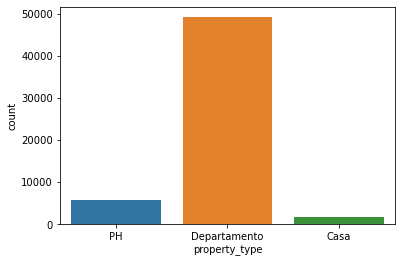

In [77]:
sns.countplot(data = d3, x = 'property_type')

Counter({'Departamento': 49142, 'PH': 5803, 'Casa': 1713})


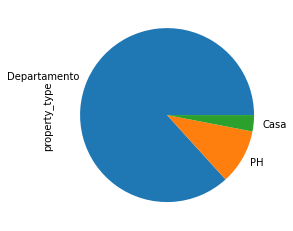

In [78]:
from collections import Counter
print(Counter(d3['property_type']))
d3['property_type'].value_counts().head(10).plot.pie()
plt.gca().set_aspect('equal')

Pie chart que muestra el desbalanceo que existe en nuestro dataset.

Evaluamos un modelo de XGBoost, para observar si logramos mejorar el rendimiento por tipo de propiedad. Antes realizamos un GridSearchCv, para encontrar los mejores hiperparametros. Incluimos alpha y lambda con el fin de observar si es necesario una regularización lasso o ridge. Además partimos de una profundidad máxima del arbol de 15.

In [79]:
from sklearn.model_selection import GridSearchCV
import xgboost as xg 

xgb_r = xg.XGBRegressor(max_depth = 15 , objective ='reg:squarederror', 
                  n_estimators = 50, seed = 123) 
param_grid = {
    'alpha': [0.7, 0.8, 1.0],
    'lambda': [0.7,0.8, 1.0]
    
    
}

XGB_cv = GridSearchCV(estimator=xgb_r, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)


In [80]:
XGB_cv.fit(X_train_3, y_train_3)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=15, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=50, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, seed=123,
                                    subsample=None, tree_method=None,
      

In [81]:
XGB_cv.best_params_

{'alpha': 0.7, 'lambda': 0.7}

El grid search nos devuelve que lo mas conveniente seria realizar una regularización ridge y lasso de 0.7.
Una vez encontrados los mejores hiperparametros procedemos a evaluar el módelo de XGboost.

In [82]:
#evaluación del modelo en train de XGBOOST
print(f'El RMSE es: {np.sqrt(mean_squared_error(y_train_3, XGB_cv.predict(X_train_3)))}')
print(f'El MAE es: {mean_absolute_error(y_train_3, XGB_cv.predict(X_train_3))}')

El RMSE es: 21679.326421629474
El MAE es: 12874.990322794913


In [83]:
#Luego en test de XGBOOST
print(f'El RMSE es: {np.sqrt(mean_squared_error(y_test_3, XGB_cv.predict(X_test_3)))}')
print(f'El MAE es: {mean_absolute_error(y_test_3, XGB_cv.predict(X_test_3))}')

El RMSE es: 45620.46568037716
El MAE es: 23570.350507605148


Evaluamos por tipo de propiedad

In [84]:
depto_pred_1 = XGB_cv.predict(X_test_d)
print(f'El RMSE es: {np.sqrt(mean_squared_error(y_test_d, depto_pred_1))}')
print(f'El MAE es: {mean_absolute_error(y_test_d, depto_pred_1)}')

casa_pred_1 = XGB_cv.predict(X_test_c)
print(f'El RMSE es: {np.sqrt(mean_squared_error(y_test_c, casa_pred_1))}')
print(f'El MAE es: {mean_absolute_error(y_test_c, casa_pred_1)}')

ph_pred_1 = XGB_cv.predict(X_test_ph)
print(f'El RMSE es: {np.sqrt(mean_squared_error(y_test_ph, ph_pred_1))}')
print(f'El MAE es: {mean_absolute_error(y_test_ph, ph_pred_1)}')

rmse_1 = {}
mae_1 = {}

rmse_1['Casa'] = np.sqrt(mean_squared_error(y_test_c, casa_pred_1))
rmse_1['Depto'] = np.sqrt(mean_squared_error(y_test_d, depto_pred_1))
rmse_1['PH'] = np.sqrt(mean_squared_error(y_test_ph, ph_pred_1))

mae_1['Casa'] = mean_absolute_error(y_test_c, casa_pred_1)
mae_1['Depto'] = mean_absolute_error(y_test_d, depto_pred_1)
mae_1['Ph'] = mean_absolute_error(y_test_ph, ph_pred_1)

rmse_1 = pd.DataFrame(rmse_1.items(), columns=['property_type', 'RMSE_xgb'])
mae_1 = pd.DataFrame(mae_1.items(), columns=['property_type', 'mae_xgb'])
error_1 = pd.concat([rmse_1, mae_1], axis=1,)
error_1

El RMSE es: 45433.82086143854
El MAE es: 23427.528479570876
El RMSE es: 49686.91369380142
El MAE es: 38641.98515625
El RMSE es: 73717.90877540213
El MAE es: 48169.17779356061


,property_type,RMSE_xgb,property_type,mae_xgb
0,Casa,49686.913694,Casa,38641.985156
1,Depto,45433.820861,Depto,23427.528480
2,PH,73717.908775,Ph,48169.177794


In [85]:
error

,property_type,RMSE_bagging,property_type,mae_bagging
0,Casa,91001.648429,Casa,62463.484545
1,Depto,45682.623214,Depto,22908.002313
2,PH,83814.188321,Ph,59799.158903


Podemos observar que el bagging regressor nos devolvio un error levemente menor que el XGboost, pero este ultimo, obtuvo un mejor resultado para los distintos tipos de propiedades. De igual manera ambos tuvieron resultados muy similares y mejoraron notablemente en comparación del modelo del proyecto 1.
Para recordar en el primer proyecto obtuvimos los siguientes resultados:

-Modelo: Árbol de Decisión(1er proyecto).

-Promedio error absoluto(MAE) en Train: 90154.17615355077

-Promedio error absoluto(MAE) en Test: 92307.58709023576

# Parte C -  Interpretación de modelos.

Una vez evaluados los modelos, decidimos quedarnos con el modelo de XGboost. Esto se debe a que el mismo obtuvo un menor error en el testeo en cuanto a los tipos de propiedades, y a su vez por que el modelado llevo un menor tiempo de procesamiento. es por esto que procederemos a evaluarlo y veremos que variables fueron las más relevantes.

In [86]:
error

,property_type,RMSE_bagging,property_type,mae_bagging
0,Casa,91001.648429,Casa,62463.484545
1,Depto,45682.623214,Depto,22908.002313
2,PH,83814.188321,Ph,59799.158903


Para evaluar las variables mas importantes del modelo utilizaremos el XGBoost, esto es debido a que el modelo de bagging no es soportable con el código a utilizar.

In [90]:
xgb_r = xg.XGBRegressor(max_depth = 15 , objective ='reg:squarederror', 
                  n_estimators = 50, seed = 123, alpha = 0.7, lamda = 0.7)

In [91]:
xgb_r.fit(X_train_3, y_train_3)

[18:04:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { lamda } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(alpha=0.7, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='', lamda=0.7,
             learning_rate=0.300000012, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0.699999988, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

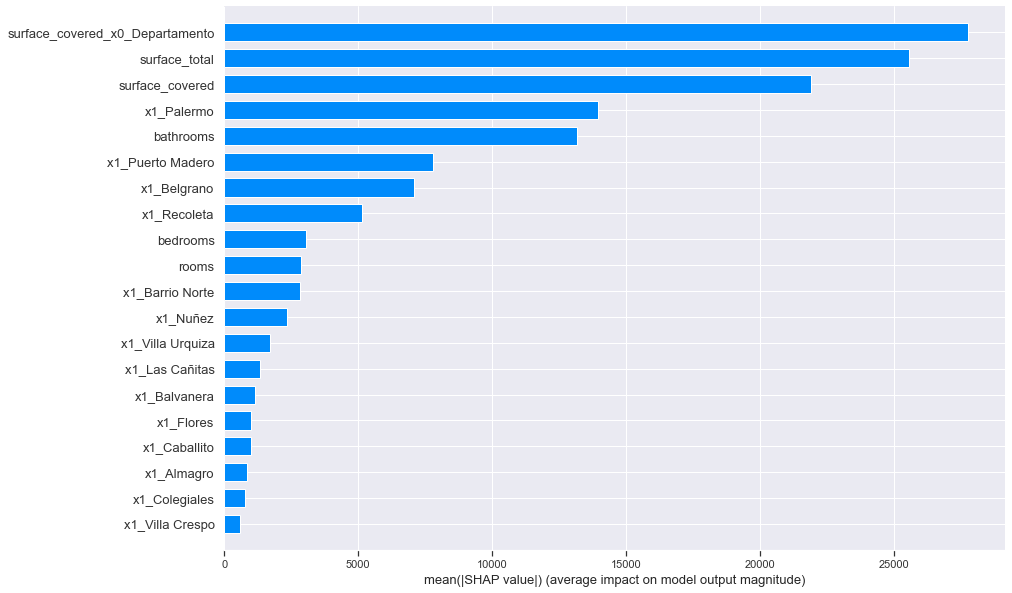

In [92]:
from utilities.plotting import plot_feature_importance, partial_dependence_plot
plot_feature_importance(model=xgb_r, data=X_test_3)

Podemos observar que las variables más relevantes para la confección de nuestro modelo son:
    
    En 1er lugar: la relación Surface_covered y Departamentos. #30000 Shap Value (average impact on model).
    
    En 2do lugar: Surface_total. #26000 Shap Value (average impact on model).
    
    En 3er lugar: Surface_covered. #24000 Shap Value (average impact on model).
    
    En 4to lugar: Palermo. #13000 Shap Value (average impact on model).

Esto se debe principalmente a que existe una gran correlación entre estas variables independientes y la variable objetivo, el precio. Es por esto que nuestro modelo decidio darles la mayor relevancia.
Además decidimos aplicar regularización en nuestro modelo de XGBoost, esto penalizo las variables menos importantes y al mismo tiempo le dio mayor relevancia a las de mayor importancia para la obtención de una correcta predicción del precio.


# Evaluación de los errores:

In [93]:
prediction_t = xgb_r.predict(X_train_3)
prediction_train = prediction_t.reshape(31698,1)
prediction_te = xgb_r.predict(X_test_3)
prediction_test = prediction_te.reshape(13564,1)


Text(0, 0.5, 'y_pred (test)')

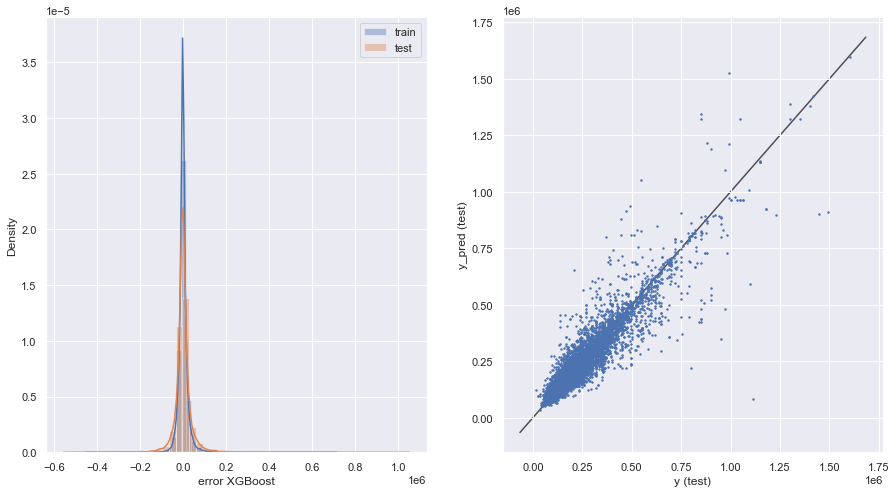

In [95]:
plt.figure(figsize = (15,8))
plt.subplot(1,2,1)
sns.distplot(y_train_3 - prediction_train, label = 'train')
sns.distplot(y_test_3 - prediction_test, label = 'test')
plt.xlabel('error XGBoost')
plt.legend()

ax = plt.subplot(1,2,2)
ax.scatter(y_test_3,prediction_test, s =2)
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

In [96]:
prediction_t = model_b.predict(X_train_3)
prediction_train = prediction_t.reshape(31698,1)
prediction_te = model_b.predict(X_test_3)
prediction_test = prediction_te.reshape(13564,1)

Text(0, 0.5, 'y_pred (test)')

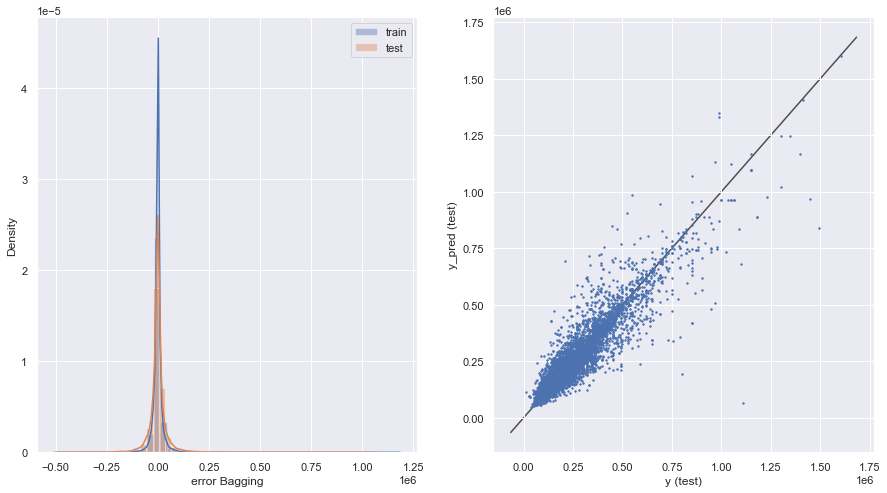

In [97]:
plt.figure(figsize = (15,8))
plt.subplot(1,2,1)
sns.distplot(y_train_3 - prediction_train, label = 'train')
sns.distplot(y_test_3 - prediction_test, label = 'test')
plt.xlabel('error Bagging')
plt.legend()

ax = plt.subplot(1,2,2)
ax.scatter(y_test_3,prediction_test, s =2)
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

Podemos observar que tanto en el modelo de bagging como en el modelo de XGBoost, la mayor densidad de los errores se encontro cercana a 0, en el caso de bagging tal vez podemos encontrar una desviación mayor pero muy pequeña. Esto quiere decir que ambos modelos estan funcionando muy bien. Al mismo tiempo podemos ver que siguen existiendo valores atípicos que no tienen un muy buen rendimiento con nuestro modelo, quizas seria recomendable no eliminar los outliers, si no, más bien buscar una manera correcta a la hora de trabajarlos. Y por que no, buscar si ayuda al funcionamiento de nuestro modelo, la interacción entre otras variables.

Tal como mencionamos con anterioridad, el error es mayor en las casas y en los Ph, esto se debe al desbalanceo que tuvimos en nuestros datos, el modelo funciona muy bien para los departamentos.

-Conclusión:-

Podemos decir que se cumplio con el objetivo, nuestro modelo mejoro notablemente en cuanto a la reducción del error de predicción comparandolo con el modelo anterior. Aún asi existe un overfitting en los datos de entrenamiento que deberia ser corregido, además el error sigue siendo alto para los tipos de propiedades diferentes a los departamentos, esto se podría corregir consiguiendo o agregando más propiedades a nuestro dataset, en este caso propiedades de casas y ph.
Por último el error se puede mejorar aún mas, deberiamos considerar tal vez otro método para trabajar los outliers o, buscar optimizar otros hiperparametros en nuestro modelo que nos ayuden a disminuir el error y el overfitting. 